# Importing Libraries

In [1]:
import os
import cv2
from sklearn.utils import shuffle 
import seaborn as sn
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Loading Dataset

In [2]:
class_names = ['Benign cases','Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['train', 'test']
    output = []    
    for dataset in datasets:        
        images = []
        labels = []        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):                
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)                 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|███████████████████████████████████████████████████████████████████████████████| 332/332 [00:01<00:00, 192.90it/s]


Loading test


100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 168.98it/s]


# Shuffle Data 

In [5]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploratory Data Analysis

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 876
Number of testing examples: 221
Each image is of size: (224, 224)


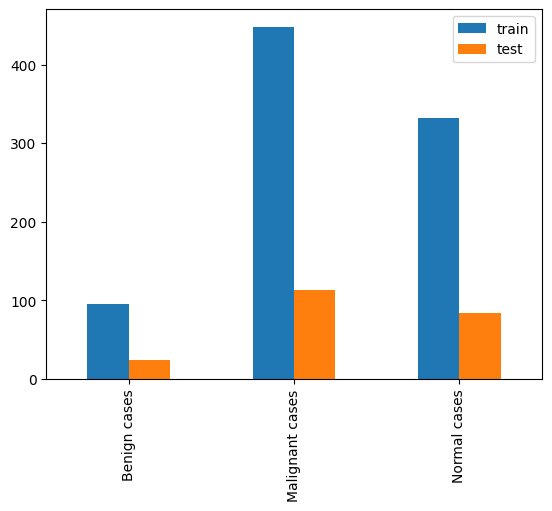

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()

plt.show()

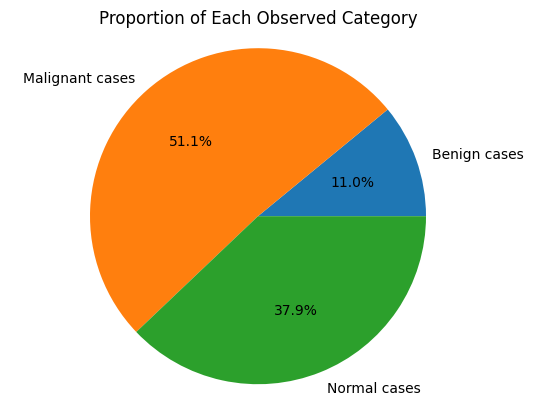

In [8]:
plt.pie(train_counts,
        explode=None, 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of Each Observed Category')
plt.show()

# Data Preprocessing

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Deep Learning Architecture

# 1. Define Network

In [10]:
import tensorflow as tf 
from tensorflow.keras.utils import plot_model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 128)               1

# 2. Compile Network

In [13]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
plot_model(model, 'CNN Architecture.jpg', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 3. Fit Network

In [15]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=30, validation_split = 0.2)

Epoch 1/30
11/11 [==============================] - 142s 11s/step - loss: 2.2004 - accuracy: 0.4843 - val_loss: 0.9506 - val_accuracy: 0.7386
Epoch 2/30
11/11 [==============================] - 51s 4s/step - loss: 0.6546 - accuracy: 0.7914 - val_loss: 0.5215 - val_accuracy: 0.8125
Epoch 3/30
11/11 [==============================] - 19s 2s/step - loss: 0.3152 - accuracy: 0.9143 - val_loss: 0.2988 - val_accuracy: 0.9034
Epoch 4/30
11/11 [==============================] - 19s 2s/step - loss: 0.1176 - accuracy: 0.9714 - val_loss: 0.1404 - val_accuracy: 0.9659
Epoch 5/30
11/11 [==============================] - 19s 2s/step - loss: 0.0542 - accuracy: 0.9857 - val_loss: 0.1199 - val_accuracy: 0.9545
Epoch 6/30
11/11 [==============================] - 19s 2s/step - loss: 0.0219 - accuracy: 0.9971 - val_loss: 0.0866 - val_accuracy: 0.9716
Epoch 7/30
11/11 [==============================] - 16s 2s/step - loss: 0.0166 - accuracy: 0.9957 - val_loss: 0.0970 - val_accuracy: 0.9773
Epoch 8/30
11/11 [

# 4.Evaluate Network

## 4.1. Classification Report

In [16]:
test_loss = model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 126ms/step - loss: 0.0303 - accuracy: 0.9774


In [17]:
test_loss

[0.030301881954073906, 0.9773755669593811]

In [18]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

7/7 [==============================] - 0s 37ms/step


In [19]:
class_names = ['Benign','Malignant', 'Normal']

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.97      1.00      0.99       113
           2       0.98      0.96      0.97        84

    accuracy                           0.98       221
   macro avg       0.98      0.96      0.97       221
weighted avg       0.98      0.98      0.98       221

Confusion Matrix : 


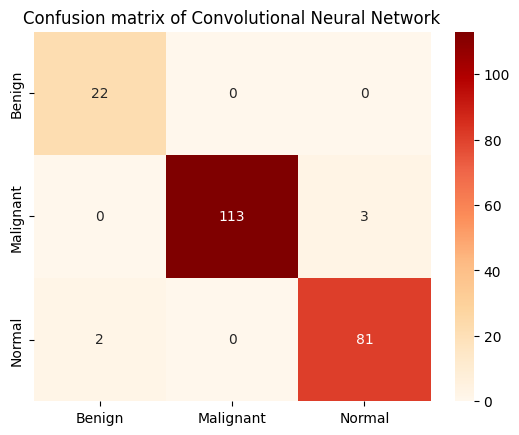

In [20]:
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(test_labels, pred_labels))
ax = plt.axes()
cm = confusion_matrix(pred_labels, test_labels)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')


sn.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix of Convolutional Neural Network')
plt.show()

In [21]:
from sklearn.metrics import classification_report
print('Classification Report')

print(classification_report(test_labels,pred_labels))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.97      1.00      0.99       113
           2       0.98      0.96      0.97        84

    accuracy                           0.98       221
   macro avg       0.98      0.96      0.97       221
weighted avg       0.98      0.98      0.98       221



## 4.2. Plotting Loss and Accuracy Curve

Text(0.5, 1.0, 'Accuracy Curves for CNN model')

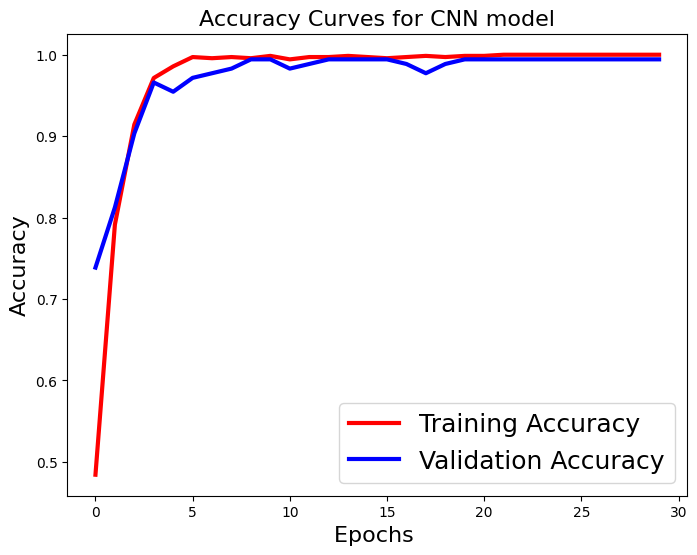

In [22]:
# Accuracy Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves for CNN model',fontsize=16)

Text(0.5, 1.0, 'Loss Curves for CNN model')

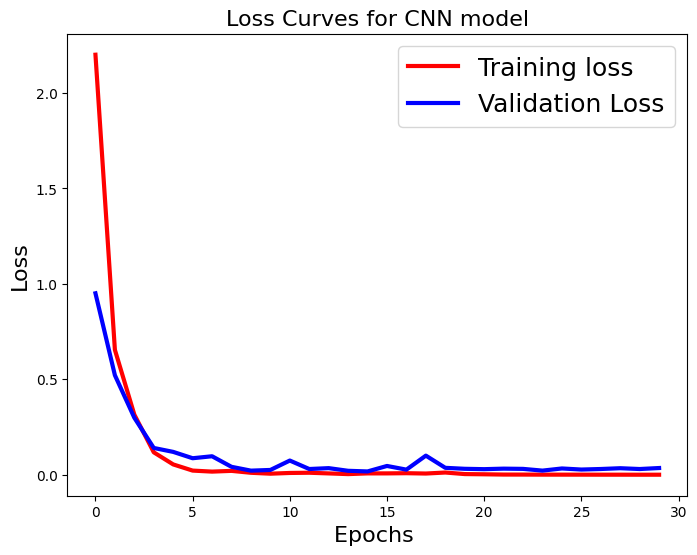

In [23]:
# Loss Curves

plt.figure(figsize=[8,6])

plt.plot(history.history['loss'],'r',linewidth=3.0)

plt.plot(history.history['val_loss'],'b',linewidth=3.0)

plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Loss',fontsize=16)

plt.title('Loss Curves for CNN model',fontsize=16)

## 4.3. Evaluation

In [24]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(test_labels,pred_labels))
print('MSE:', metrics.mean_squared_error(test_labels,pred_labels))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels,pred_labels)))

MAE: 0.03167420814479638
MSE: 0.049773755656108594
RMSE: 0.2231003264365801


In [25]:
from sklearn.metrics import precision_score
print("Precision Score : ",precision_score(test_labels,pred_labels, average='weighted'))


from sklearn.metrics import recall_score
print("Recall Score : ",recall_score(test_labels,pred_labels,average='weighted'))


from sklearn.metrics import f1_score
print("f1_score : ",f1_score(test_labels,pred_labels,average='weighted'))

Precision Score :  0.9776176010016036
Recall Score :  0.9773755656108597
f1_score :  0.977200010562317


##  4.4. Make Predictions

In [26]:
preds = model.predict(test_images)

print('shape of preds: ', preds.shape)

7/7 [==============================] - 0s 38ms/step
shape of preds:  (221, 3)


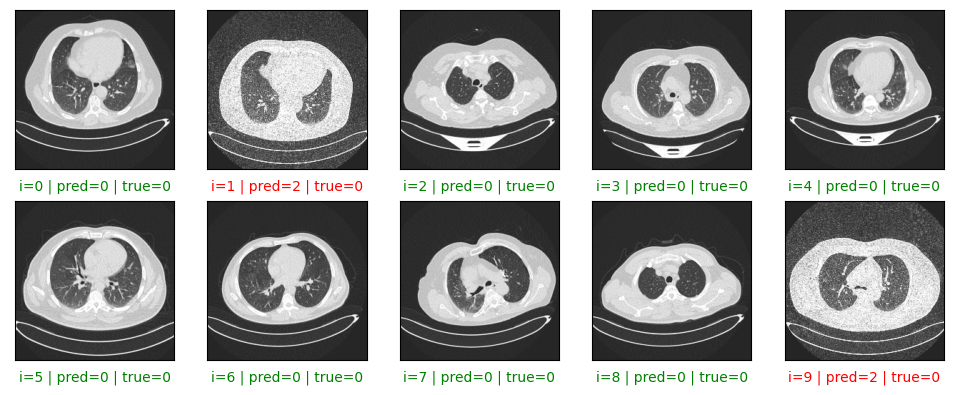

In [27]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(test_labels[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(test_images[start_index + i], cmap='binary')
plt.show()